In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
40112,NaN,NaN,International,2020-08-26,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40113,NaN,NaN,International,2020-08-27,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40114,NaN,NaN,International,2020-08-28,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


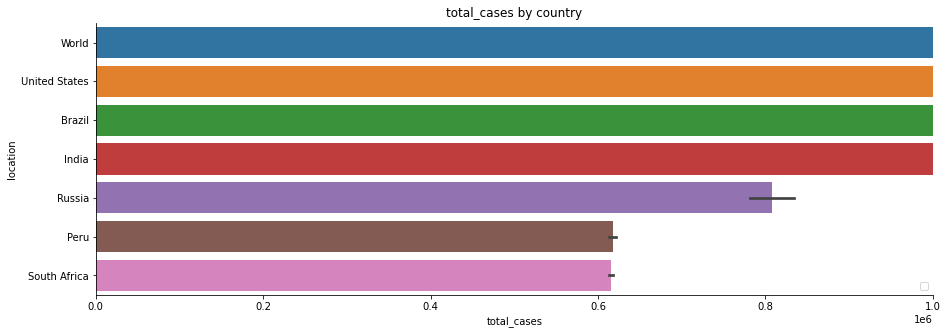

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


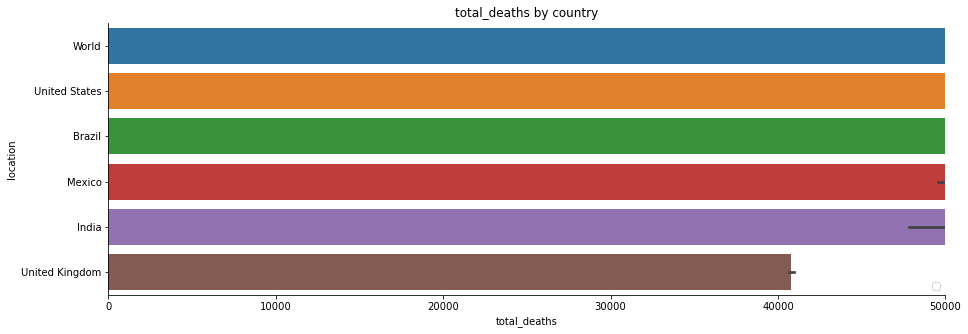

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


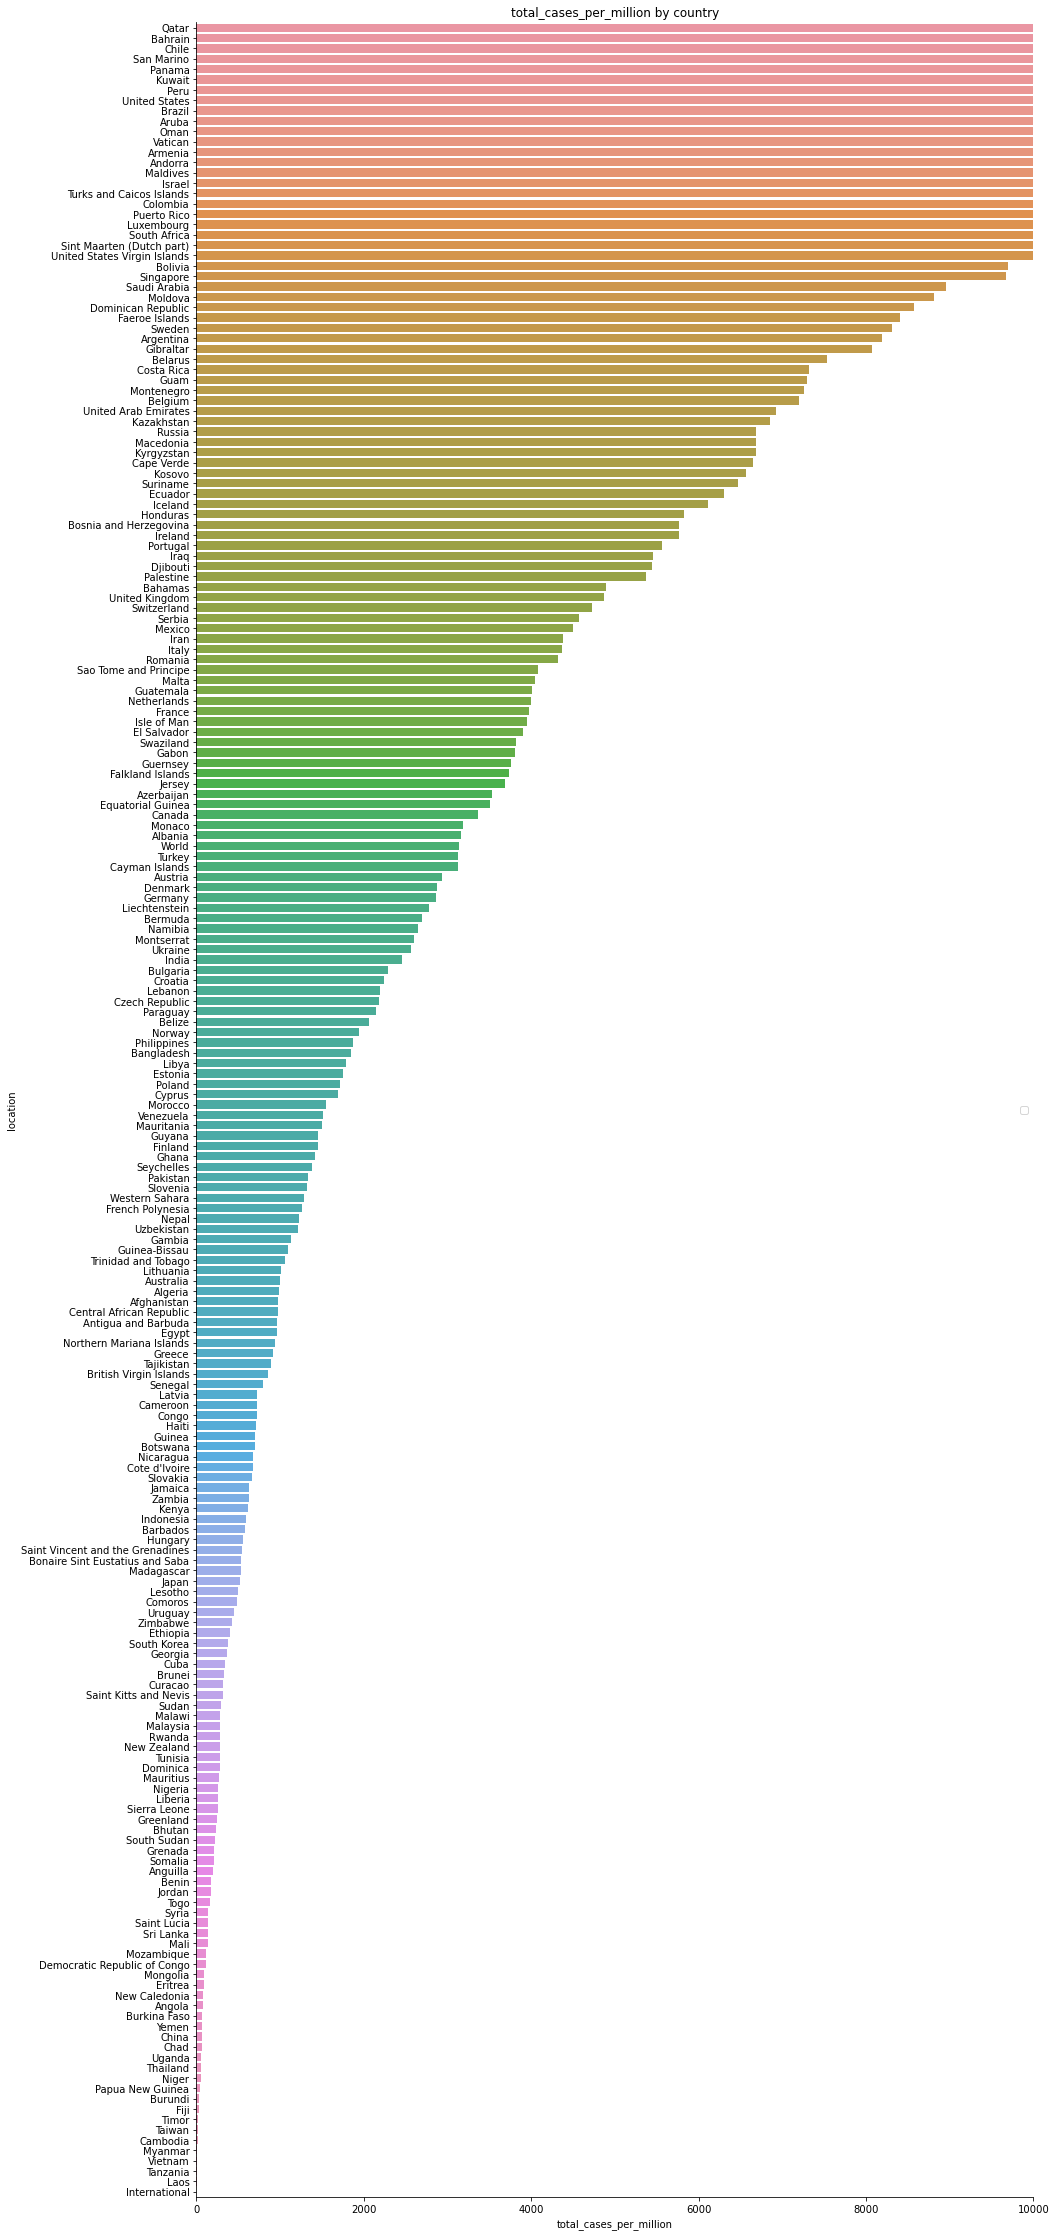

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


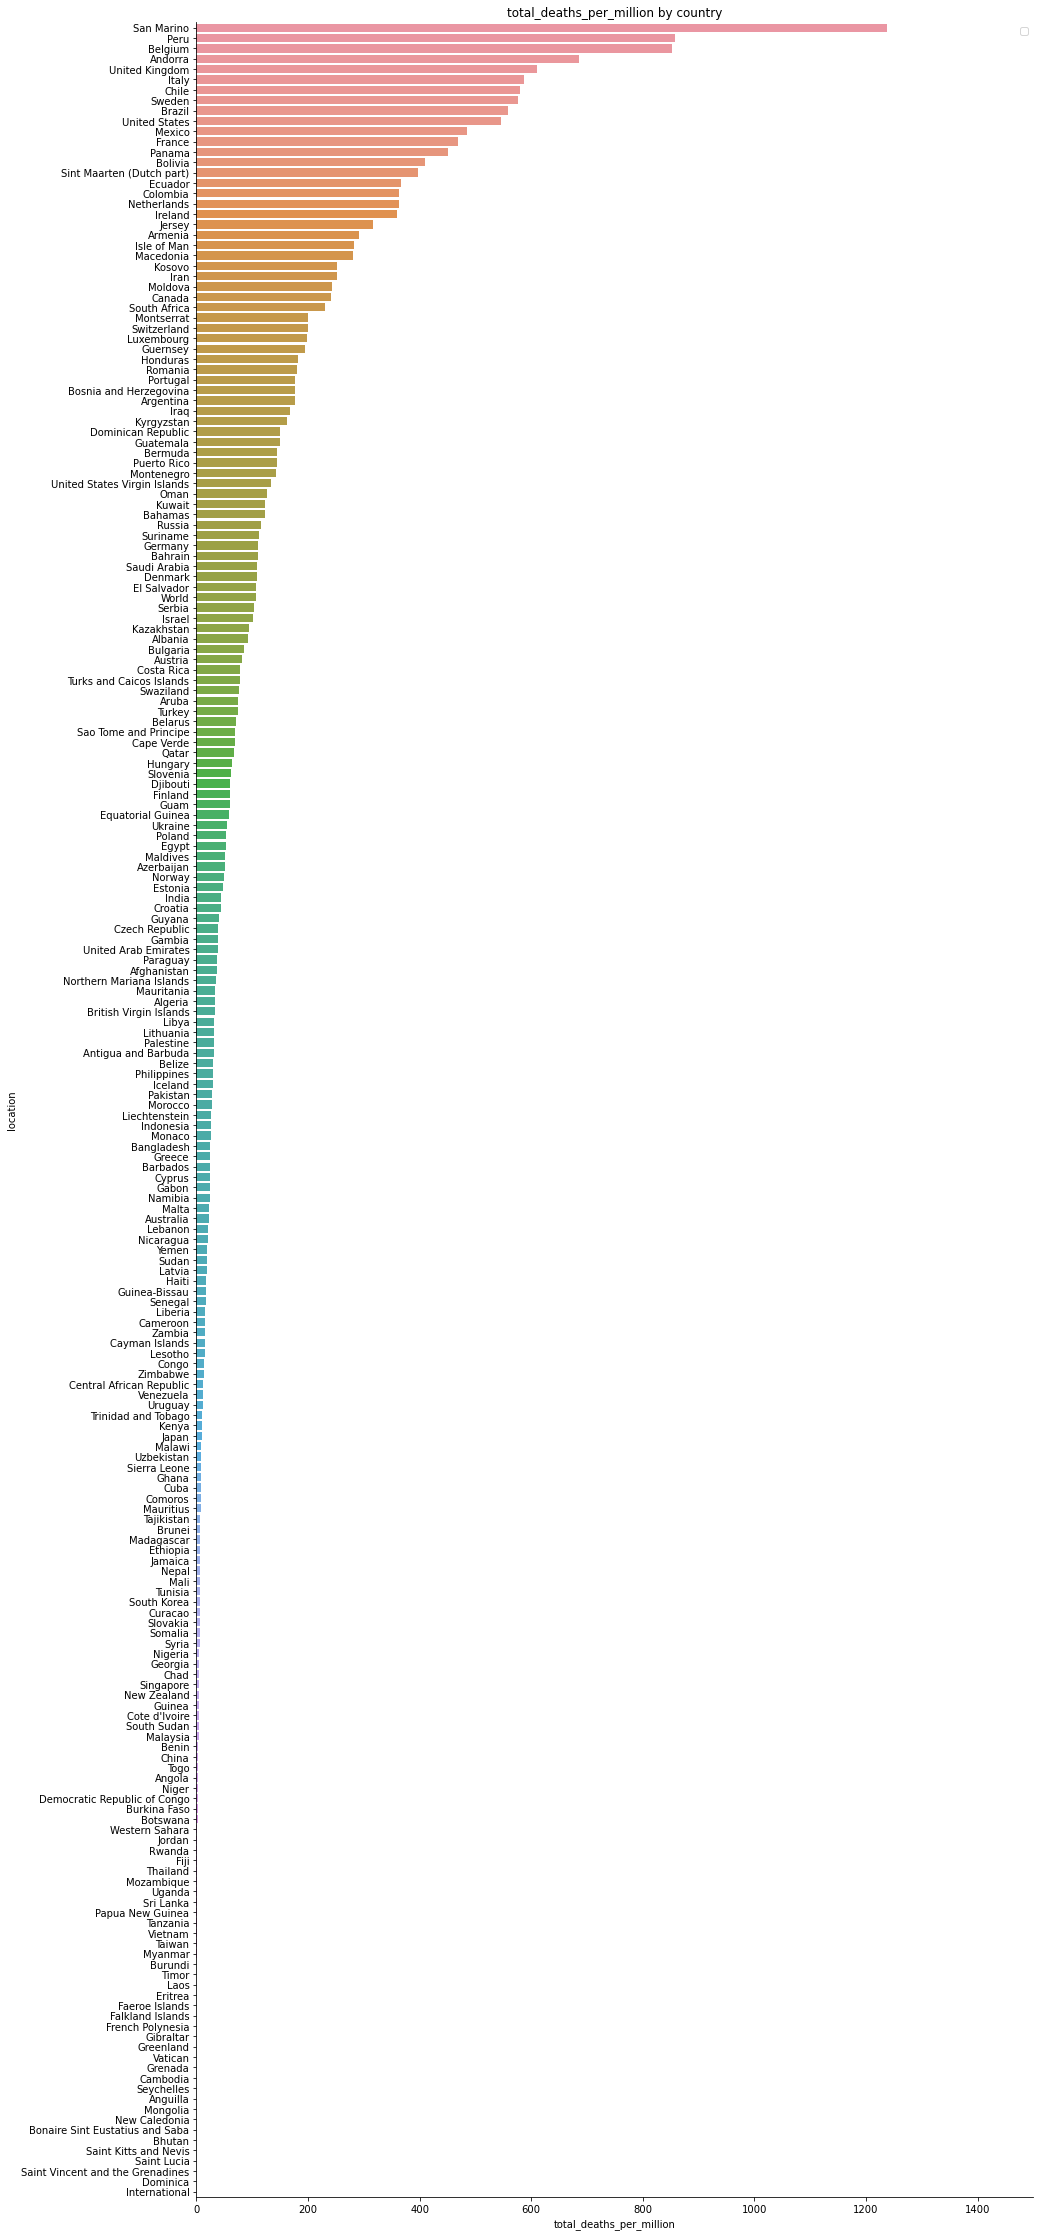

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

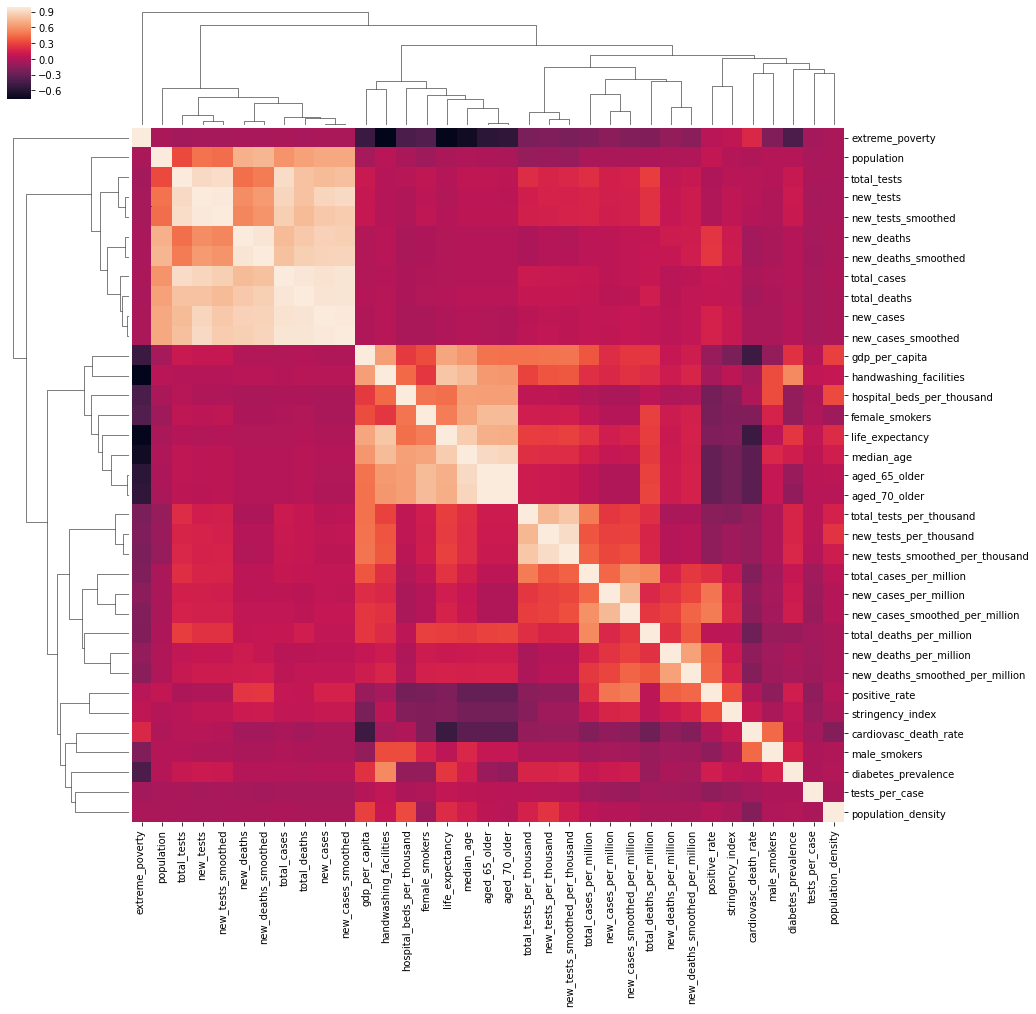

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9994274655995893 (+/- 0.00042312588226188334)
Coef :  [1.03838755e+00 9.35056358e-05 9.72421448e-05]
3 Last_days :  [[23933380 24211468 24473843]]
Today :  24473843
Prediction + :  462151
Tomorow :  24935994
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996293743180903 (+/- 8.608971127077184e-05)
Coef :  [0.01627224 0.48136396 0.51255325]
3 Last_days :  [[819808 826122 832002]]
Today :  832002
Prediction + :  7921
Tomorow :  839923
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9867316095220794 (+/- 0.010897030355090457)
Coef :  [-0.6848592   0.73163348  0.9552402 ]
3 Last_days :  [[248158 253587 259698]]
Today :  259698
Prediction + :  4182
Tomorow :  263880
                                     
--------- Total Death -----------------
                                     
R^2: 0.42027559566730627 (+/- 0.8099731082761666)
Coef :  [-0.75307153  0.7885976   0.96353232]
3 Last_days :  [[30544 30544 30576]]
Today :  30576
Prediction + :  21
Tomorow :  30597
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9099012263198453 (+/- 0.06556258345648794)
Coef :  [-0.32411681 -0.02080467  1.33919122]
3 Last_days :  [[89752 89784 89814]]
Today :  89814
Prediction + :  34
Tomorow :  89848
                                     
--------- Total Death -----------------
                                     
R^2: -247.1631450646953 (+/- 350.79185966223645)
Coef :  [-0.07693279  0.01243446  1.05643445]
3 Last_days :  [[4712 4713 4715]]
Today :  4715
Prediction + :  6
Tomorow :  4721
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8315361732527241 (+/- 0.23689856609323534)
Coef :  [-0.83009646  0.90113342  0.92824121]
3 Last_days :  [[261174 262540 263949]]
Today :  263949
Prediction + :  1222
Tomorow :  265171
                                     
--------- Total Death -----------------
                                     
R^2: 0.7644430413572745 (+/- 0.3060760018283829)
Coef :  [-0.8305257   0.90056867  0.92909649]
3 Last_days :  [[35445 35458 35463]]
Today :  35463
Prediction + :  32
Tomorow :  35495
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6470660480945029 (+/- 0.4890205642466183)
Coef :  [-0.59405419  0.43641562  1.15915174]
3 Last_days :  [[412553 419849 429507]]
Today :  429507
Prediction + :  6763
Tomorow :  436270
                                     
--------- Total Death -----------------
                                     
R^2: 0.1505402842438733 (+/- 1.003903942960063)
Coef :  [-0.72288663  0.62075695  1.10113095]
3 Last_days :  [[28924 28971 28996]]
Today :  28996
Prediction + :  45
Tomorow :  29041
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.987327694009465 (+/- 0.01760618805039659)
Coef :  [0.06432558 0.47172807 0.48053192]
3 Last_days :  [[5779028 5821876 5867785]]
Today :  5867785
Prediction + :  82848
Tomorow :  5950633
                                     
--------- Total Death -----------------
                                     
R^2: 0.8364709005691502 (+/- 0.22967285361015233)
Coef :  [-0.561732    0.74025471  0.82404172]
3 Last_days :  [[178486 179714 180824]]
Today :  180824
Prediction + :  1256
Tomorow :  182080
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9171303031293544 (+/- 0.1156221280264314)
Coef :  [-0.75082708  0.86260568  0.88834791]
3 Last_days :  [[327798 328846 330368]]
Today :  330368
Prediction + :  1145
Tomorow :  331513
                                     
--------- Total Death -----------------
                                     
R^2: 0.3816224636531748 (+/- 0.8431835996191569)
Coef :  [-0.77346657  0.83219672  0.9407054 ]
3 Last_days :  [[41449 41465 41477]]
Today :  41477
Prediction + :  49
Tomorow :  41526
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9807179612092822 (+/- 0.025018378591614984)
Coef :  [-0.80198754  0.85972137  0.94196326]
3 Last_days :  [[236429 237936 239507]]
Today :  239507
Prediction + :  1346
Tomorow :  240853
                                     
--------- Total Death -----------------
                                     
R^2: 0.38627214359879325 (+/- 0.8566202635840244)
Coef :  [-0.79309652  0.84161121  0.95082889]
3 Last_days :  [[9280 9285 9288]]
Today :  9288
Prediction + :  10
Tomorow :  9298
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -1.43955099355992 (+/- 3.4489638940203116)
Coef :  [0.20140575 0.40706028 0.40343967]
3 Last_days :  [[361150 363363 367796]]
Today :  367796
Prediction + :  2544
Tomorow :  370340
                                     
--------- Total Death -----------------
                                     
R^2: 0.9459691648244951 (+/- 0.07570796138452779)
Coef :  [-0.01148009  0.5167284   0.50725902]
3 Last_days :  [[20776 20901 21137]]
Today :  21137
Prediction + :  195
Tomorow :  21332
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9982812030525001 (+/- 0.0021556101680761663)
Coef :  [-0.74366017  0.85148817  0.88946255]
3 Last_days :  [[261194 262507 263998]]
Today :  263998
Prediction + :  1108
Tomorow :  265106
                                     
--------- Total Death -----------------
                                     
R^2: 0.9991828030087874 (+/- 0.0008471355014136219)
Coef :  [-0.81302232  0.89572287  0.91429186]
3 Last_days :  [[6163 6183 6209]]
Today :  6209
Prediction + :  17
Tomorow :  6226
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4512485991621776 (+/- 0.7714118752747462)
Coef :  [-0.16871814  0.50614907  0.67901464]
3 Last_days :  [[3669995 3717156 3761391]]
Today :  3761391
Prediction + :  60655
Tomorow :  3822046
                                     
--------- Total Death -----------------
                                     
R^2: 0.4891735475921913 (+/- 0.7155778623283836)
Coef :  [-0.13304596  0.52718172  0.61875775]
3 Last_days :  [[116580 117665 118649]]
Today :  118649
Prediction + :  1531
Tomorow :  120180
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(24473843, 832002, 24935994, 839923),
 (259698, 30576, 263880, 30597),
 (263949, 35463, 265171, 35495),
 (429507, 28996, 436270, 29041),
 (5867785, 180824, 5950633, 182080),
 (89814, 4715, 89848, 4721),
 (330368, 41477, 331513, 41526),
 (239507, 9288, 240853, 9298),
 (367796, 21137, 370340, 21332),
 (263998, 6209, 265106, 6226),
 (3761391, 118649, 3822046, 120180)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-28,France,263880.0,0.0,30597.0,0.0,0.0,0.0
0,2020-08-28,China,89848.0,0.0,4721.0,0.0,0.0,0.0
0,2020-08-28,Italy,265171.0,0.0,35495.0,0.0,0.0,0.0
0,2020-08-28,Spain,436270.0,0.0,29041.0,0.0,0.0,0.0
0,2020-08-28,United States,5950633.0,0.0,182080.0,0.0,0.0,0.0
0,2020-08-28,World,24935994.0,0.0,839923.0,0.0,0.0,0.0
0,2020-08-28,United Kingdom,331513.0,0.0,41526.0,0.0,0.0,0.0
0,2020-08-28,Germany,240853.0,0.0,9298.0,0.0,0.0,0.0
0,2020-08-28,Iran,370340.0,0.0,21332.0,0.0,0.0,0.0
0,2020-08-28,Turkey,265106.0,0.0,6226.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")